In [1]:
import pandas as pd
import numpy as np
import scanpy as sc
import scvi

C:\Users\tobij\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\utils\_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


### Creating the adata object

In [2]:
cell_barcodes = []
for i in range(3085):
    cell_barcodes.append(f'cell_{i+1}')

In [3]:
len(cell_barcodes)

3085

In [4]:
column_names = ['ensembl_geneid', 'gene_symbol'] + cell_barcodes

In [5]:
# I should always use the header=None argument whenever there are no defined column names, and then the names=... argument to set the column names
df = pd.read_csv('GSM2758471_PJ016.filtered.matrix.txt', delimiter='\t', header=None, names=column_names)

In [6]:
# Selecting the only object columns and checking for any 'na' values
df.select_dtypes(include='object').isna().sum()

ensembl_geneid    0
gene_symbol       0
dtype: int64

In [7]:
# Selecting the only object columns and checking for any missing values
df.select_dtypes(include='object').isnull().sum()

ensembl_geneid    0
gene_symbol       0
dtype: int64

In [8]:
# Showing that the others are truly numerical columns
df.select_dtypes(include='number').isna().sum()

cell_1       0
cell_2       0
cell_3       0
cell_4       0
cell_5       0
            ..
cell_3081    0
cell_3082    0
cell_3083    0
cell_3084    0
cell_3085    0
Length: 3085, dtype: int64

In [9]:
# Checking the numerical columns for any 'na' values
np.where(df.isna())

(array([], dtype=int64), array([], dtype=int64))

In [10]:
# Checking the numerical columns for any missing values
np.where(df.isnull())

(array([], dtype=int64), array([], dtype=int64))

In [11]:
# Dropping the ensembl gene id column. I only need the gene symbols
df.drop('ensembl_geneid', axis=1, inplace=True)

In [12]:
df.set_index('gene_symbol', inplace=True)
df.index.name = None # To remove 'gene_symbol'

In [13]:
df.head()

,cell_1,cell_2,cell_3,cell_4,cell_5,cell_6,cell_7,cell_8,cell_9,cell_10,...,cell_3076,cell_3077,cell_3078,cell_3079,cell_3080,cell_3081,cell_3082,cell_3083,cell_3084,cell_3085
SLC7A10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RAX,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC007228.11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AC092667.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
RP11-131K5.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df.to_csv('relabelled_raw_GSM2758471_PJ016_matrix.csv')

In [15]:
# Reading the relabelled df with scanpy to give an adata object
adata = sc.AnnData(df).T

C:\Users\tobij\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
C:\Users\tobij\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [16]:
adata.X.shape

(3085, 60725)

In [17]:
adata.obs.head()

""
cell_1
cell_2
cell_3
cell_4
cell_5


In [18]:
adata.var.head()

""
SLC7A10
RAX
AC007228.11
AC092667.2
RP11-131K5.1


In [19]:
adata.X

array([[0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

### Removing doublets (An optional step)

In [ ]:
# Training an scvi model to predict doublets
scvi.model.SCVI.setup_anndata(adata)
vae = scvi.model.SCVI(adata)
vae.train()

In [ ]:
solo = scvi.external.SOLO.from_scvi_model(vae)
solo.train()

In [ ]:
# Predicting
df2 = solo.predict()

In [ ]:
df['prediction'] = solo.predict(soft=False) # soft = False gives the class with the highest proba, but not the proba

In [ ]:
df.groupby('prediction').count()

In [ ]:
# Finding the difference to use the new column as the base for filtering doublets out
df['dif'] = df.doublet - df.singlet
df

In [ ]:
pred_doub = df[df.prediction == 'doublet']
pred_doub

In [ ]:
import seaborn as sns
sns.displot(pred_doub, x='dif')

In [ ]:
doublets = df[(df.prediction == 'doublet') & (df.dif > 1)]
doublets

In [ ]:
# import adata again
adata = sc.AnnData(df).T

In [ ]:
adata.obs['doublet'] = adata.obs.index.isin(doublets.index)

In [ ]:
adata.obs

In [ ]:
adata = adata[~adata.obs.doublet]

In [ ]:
adata.X.shape

### Preprocessing

In [20]:
adata

AnnData object with n_obs × n_vars = 3085 × 60725

In [21]:
# Picking mt genes out
adata.var['mt'] = adata.var_names.str.startswith('MT-')

In [22]:
np.where(adata.var.mt)

(array([ 5576,  6673,  8225,  8260, 11852, 12095, 12501, 14811, 15021,
        17481, 17718, 17942, 18064, 19399, 21611, 22148, 22680, 23730,
        24334, 26228, 26867, 29075, 30821, 32029, 32858, 35876, 36178,
        41485, 50240, 51302, 51598, 54231, 54709, 56209, 56706, 57350,
        59232], dtype=int64),)

In [23]:
adata.var[adata.var.mt].head()

,mt
MT-TG,True
MT-ATP6,True
MT-TL1,True
MT-TA,True
MT-RNR2,True


In [24]:
# Picking ribosomal genes out
ribo_url = "http://software.broadinstitute.org/gsea/msigdb/download_geneset.jsp?geneSetName=KEGG_RIBOSOME&fileType=txt"
ribo_genes = pd.read_table(ribo_url, skiprows=2, header=None)

In [25]:
ribo_genes.head()

,0
0,FAU
1,MRPL13
2,RPL10
3,RPL10A
4,RPL10L


In [26]:
adata.var[adata.var_names.isin(ribo_genes[0].values)].head()

,mt
RPS5,False
RPL19,False
RPLP1,False
RPS29,False
RPL30,False


In [27]:
adata.var['ribo'] = adata.var_names.isin(ribo_genes[0].values)

In [28]:
adata

AnnData object with n_obs × n_vars = 3085 × 60725
    var: 'mt', 'ribo'

In [29]:
# Calculating QC metrics with the mt and ribo columns
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt', 'ribo'], percent_top=None, log1p=False, inplace=True)

In [30]:
adata

AnnData object with n_obs × n_vars = 3085 × 60725
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [31]:
# Commencing the filtration of genes and cells
adata.var.sort_values(by='n_cells_by_counts') # n_cells_by_counts means "how many cells is a particular gene expressed in?"

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts
AC107982.4,False,False,0,0.000000,100.000000,0
RP11-12M5.1,False,False,0,0.000000,100.000000,0
USP17L29,False,False,0,0.000000,100.000000,0
RNU1-140P,False,False,0,0.000000,100.000000,0
STARP1,False,False,0,0.000000,100.000000,0
...,...,...,...,...,...,...
RPL41,False,True,3051,17.589303,1.102107,54263
ACTB,False,False,3054,17.230470,1.004862,53156
TUBA1A,False,False,3057,23.898865,0.907618,73728
MALAT1,False,False,3070,74.906321,0.486224,231086


In [32]:
# To make sure that each of the genes is in at least 3 cells
sc.pp.filter_genes(adata, min_cells=3)

C:\Users\tobij\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [33]:
adata.var.sort_values(by='n_cells_by_counts')

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells
ARL6IP1P1,False,False,3,0.000972,99.902755,3,3
RP11-77K12.5,False,False,3,0.001297,99.902755,4,3
RP11-368N21.5,False,False,3,0.000972,99.902755,3,3
LINC00282,False,False,3,0.001621,99.902755,5,3
RP11-395E19.2,False,False,3,0.000972,99.902755,3,3
...,...,...,...,...,...,...,...
RPL41,False,True,3051,17.589303,1.102107,54263,3051
ACTB,False,False,3054,17.230470,1.004862,53156,3054
TUBA1A,False,False,3057,23.898865,0.907618,73728,3057
MALAT1,False,False,3070,74.906321,0.486224,231086,3070


In [34]:
adata.obs.sort_values(by='n_genes_by_counts') # n_genes_by_counts means "how many genes are present in each cell?"

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo
cell_3047,543,1062,1,0.094162,179,16.854991
cell_3084,590,1001,12,1.198801,171,17.082917
cell_3077,612,1010,23,2.277228,102,10.099010
cell_3022,660,1094,0,0.000000,76,6.946984
cell_2928,679,1259,5,0.397141,129,10.246227
...,...,...,...,...,...,...
cell_3,6854,26079,54,0.207063,1129,4.329154
cell_9,6879,25110,88,0.350458,2212,8.809239
cell_4,6943,25842,68,0.263138,2092,8.095349
cell_7,6966,25570,25,0.097771,1517,5.932734


In [35]:
# To make sure that each of the genes is in at least 3 cells
sc.pp.filter_cells(adata, min_genes=200)

C:\Users\tobij\AppData\Local\Programs\Python\Python39\lib\site-packages\anndata\_core\anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [36]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes
cell_1,6841,26176,40,0.152812,3446,13.164731,6813
cell_2,7390,26091,71,0.272124,2515,9.639339,7368
cell_3,6854,26079,54,0.207063,1129,4.329154,6832
cell_4,6943,25842,68,0.263138,2092,8.095349,6930
cell_5,6812,25754,175,0.679506,1069,4.150812,6801
...,...,...,...,...,...,...,...
cell_3081,720,1007,4,0.397219,151,14.995035,702
cell_3082,733,1006,3,0.298211,67,6.660040,732
cell_3083,782,1004,9,0.896414,101,10.059761,782
cell_3084,590,1001,12,1.198801,171,17.082917,590


In [37]:
adata.var_names_make_unique()

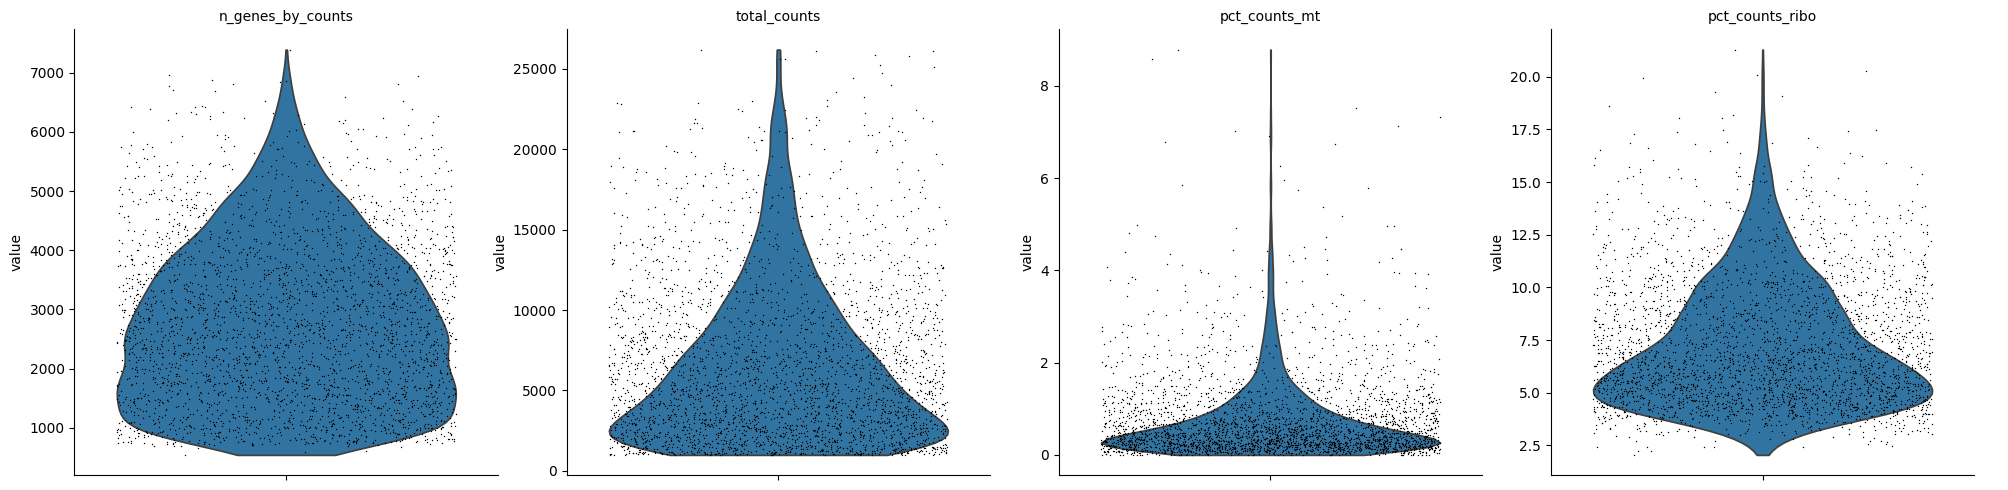

In [38]:
# Making violin plots to get thresholds to filter out outliers in specific count columns
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt', 'pct_counts_ribo'], jitter=0.4, multi_panel=True)

In [39]:
# Filtering for only cells with gene counts within the 98th percentile
upper_lim = np.quantile(adata.obs.n_genes_by_counts.values, .98)

In [40]:
adata[adata.obs.n_genes_by_counts < upper_lim]

View of AnnData object with n_obs × n_vars = 3023 × 27557
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

In [41]:
adata = adata[adata.obs.pct_counts_mt < 6] # 6 is the threshold value for %mt

In [42]:
adata = adata[adata.obs.pct_counts_ribo < 20] # 20 is the threshold value for %ribo because since it is a glioma sample, a higher percentage of ribo genes is expected

In [43]:
adata

View of AnnData object with n_obs × n_vars = 3072 × 27557
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'

### Normalization

In [44]:
adata.X

ArrayView([[0, 0, 0, ..., 0, 0, 1],
           [0, 0, 7, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           ...,
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0],
           [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [45]:
adata.raw = adata.copy()

In [46]:
adata.X.sum(axis=1)

array([26147, 26068, 26056, ...,  1004,  1001,  1000], dtype=int64)

In [47]:
# Normalizing every cell to 10,000 UMI
sc.pp.normalize_total(adata, target_sum=1e4)

In [48]:
adata.X.sum(axis=1)

array([ 9999.999, 10000.   ,  9999.999, ..., 10000.   , 10000.   ,
       10000.   ], dtype=float32)

In [49]:
# Changing to log counts
sc.pp.log1p(adata)

In [50]:
adata.X.sum(axis=1)

array([4537.789 , 5030.342 , 4721.475 , ..., 1987.3035, 1544.0505,
       2003.8766], dtype=float32)

### Clustering

In [51]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000)

In [52]:
adata.var[adata.var.highly_variable == True]

,mt,ribo,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,n_cells,highly_variable,means,dispersions,dispersions_norm
AC092667.2,False,False,7,0.002269,99.773096,7,7,True,0.004914,1.767062,1.713560
TRIM63,False,False,880,1.014911,71.474878,3131,880,True,0.870784,2.337165,4.145105
STARD8,False,False,74,0.027877,97.601297,86,74,True,0.050577,1.627621,1.415897
SKA2,False,False,1411,1.321232,54.262561,4076,1411,True,1.116082,1.786005,1.618042
RTN1,False,False,688,0.777310,77.698541,2398,688,True,0.738477,2.584731,5.132843
...,...,...,...,...,...,...,...,...,...,...,...
ZNF526,False,False,57,0.019773,98.152350,61,57,True,0.032834,1.719444,1.611909
POU2F2,False,False,188,0.098865,93.905997,305,188,True,0.154824,1.703784,1.578480
OLIG2,False,False,601,0.654133,80.518639,2018,601,True,0.793071,2.305395,4.018346
TCF12,False,False,1476,1.232091,52.155592,3801,1476,True,1.110917,1.734922,1.431255


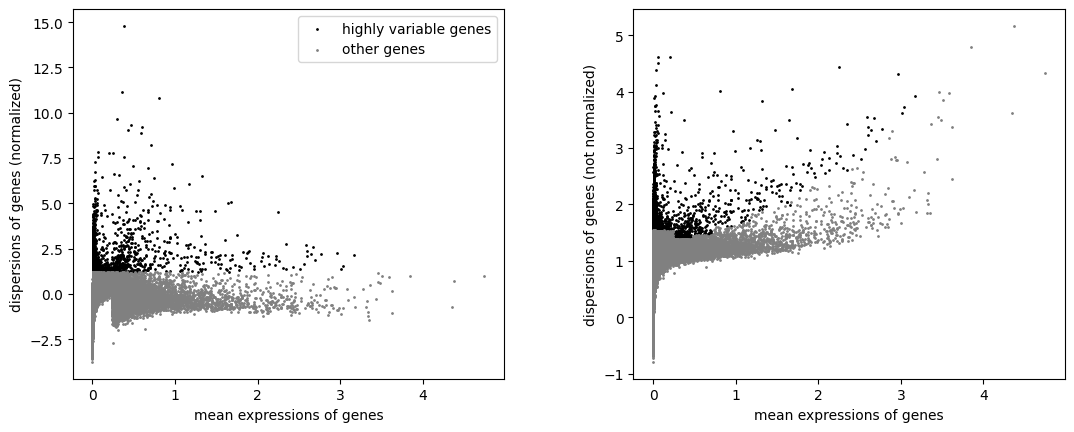

In [53]:
# Plotting to see highly variable genes
# Highly Variable Genes (HVGs) are genes that show substantial variation across cells, making them informative for distinguishing different cell types or states in single-cell RNA-seq (scRNA-seq) data
sc.pl.highly_variable_genes(adata)

In [54]:
adata = adata[:, adata.var.highly_variable] # To get all the data for only the highly variable genes

In [55]:
# sc.pp.regress_out() is used to remove the effect of unwanted variables from gene expression data
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt', 'pct_counts_ribo'])

C:\Users\tobij\AppData\Local\Programs\Python\Python39\lib\site-packages\scanpy\preprocessing\_simple.py:657: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [56]:
adata.X

array([[-1.05480904e-03, -4.66981088e-01, -1.79543177e-02, ...,
        -4.55915952e-01, -6.73898869e-01, -5.30176458e-01],
       [-1.68886356e-03, -6.86047952e-01, -2.64036934e-02, ...,
         6.68233310e-01,  6.35497292e-01,  6.72245529e-01],
       [-3.05664554e-03,  7.39695791e-01,  2.86985361e-01, ...,
        -2.07738263e-02, -1.71340748e-01, -1.92575960e-01],
       ...,
       [-1.25966441e-03, -1.11326459e-01, -1.49884558e-02, ...,
         2.38349816e+00,  2.54371246e+00, -2.33203532e-01],
       [ 9.16551555e-04,  3.99108708e-01, -1.05053829e-03, ...,
        -1.49887141e+00, -1.62996749e+00, -5.13553995e-01],
       [-3.66634404e-03, -5.48784504e-01, -2.26093047e-02, ...,
         3.45685566e+00, -2.56027228e-01, -9.62943326e-03]])

In [57]:
sc.pp.scale(adata, max_value=10) # Scaling makes it such that each gene has a mean of 0 and a standard deviation of 1, while capping extreme values at max_value=10.

In [58]:
sc.tl.pca(adata, svd_solver='arpack')

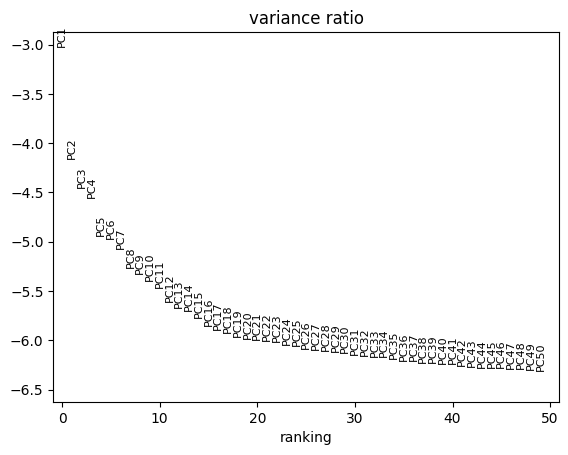

In [59]:
# Plotting the pca variance ratio to select a threshold for number of pca components
sc.pl.pca_variance_ratio(adata, log=True, n_pcs = 50)

In [60]:
# 23 is the threshold of pca components
sc.pp.neighbors(adata, n_pcs = 23)

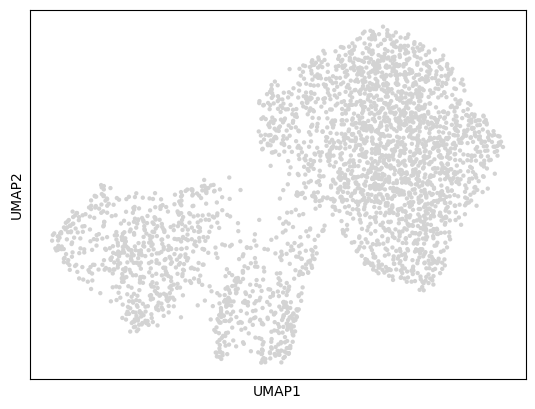

In [61]:
sc.tl.umap(adata)
sc.pl.umap(adata)

In [62]:
# !pip install leidenalg

In [63]:
sc.tl.leiden(adata, resolution = 0.5)

C:\Users\tobij\AppData\Local\Temp\ipykernel_14728\3246266323.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution = 0.5)


In [64]:
print(f'There are {adata.obs.leiden.nunique()} clusters')

There are 8 clusters


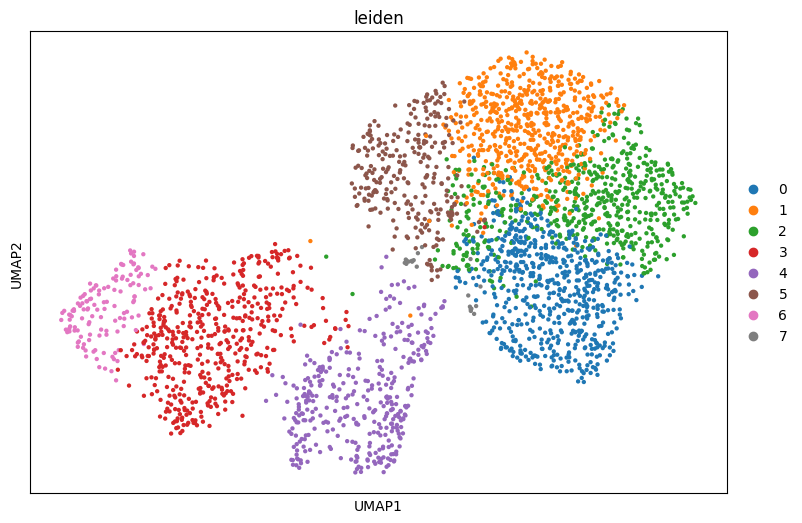

In [65]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(adata, color=['leiden'], ax=ax) 

In [66]:
# Using sc.tl first to rank the gene groups by the leiden algorithm
sc.tl.rank_genes_groups(adata, 'leiden')

In [67]:
# To plot the top ranked gene groups
# sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)

In [68]:
adata.obs

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
cell_1,6841,26176,40,0.152812,3446,13.164731,6813,3
cell_2,7390,26091,71,0.272124,2515,9.639339,7368,3
cell_3,6854,26079,54,0.207063,1129,4.329154,6832,2
cell_4,6943,25842,68,0.263138,2092,8.095349,6930,3
cell_5,6812,25754,175,0.679506,1069,4.150812,6801,0
...,...,...,...,...,...,...,...,...
cell_3081,720,1007,4,0.397219,151,14.995035,702,5
cell_3082,733,1006,3,0.298211,67,6.660040,732,5
cell_3083,782,1004,9,0.896414,101,10.059761,782,4
cell_3084,590,1001,12,1.198801,171,17.082917,590,5


In [69]:
# To get the df of the top ranked gene groups (using sc.get instead of sc.pl)
markers = sc.get.rank_genes_groups_df(adata, None)

In [70]:
markers = markers[(markers.pvals_adj < 0.05) & (markers.logfoldchanges > 0.5)] # I chose positive fold change markers because I want to focus on those with the greatest expression

In [71]:
markers.head()

,group,names,scores,logfoldchanges,pvals,pvals_adj
0,0,PSAP,13.894073,17.422945,1.875871e-39,3.829140e-37
1,0,SMYD3,12.215199,5.614346,1.772697e-31,2.282720e-29
2,0,GRN,12.008278,4.910494,2.231322e-30,2.616533e-28
3,0,FBXO32,11.900820,6.119643,3.124101e-30,3.632526e-28
4,0,SOD1,11.745515,11.111899,2.836036e-29,3.076876e-27


In [72]:
markers.to_csv('markers.csv', index=False)

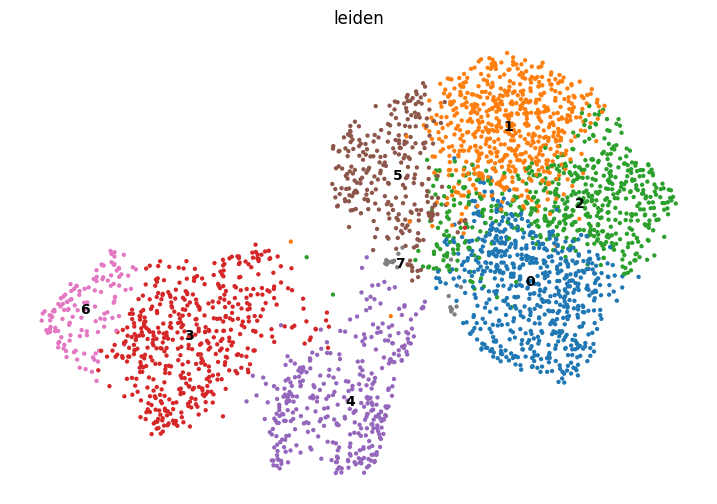

In [73]:
# Plotting, but this time, with legends
fig, ax = plt.subplots(figsize=(9, 6))
sc.pl.umap(adata, color = ['leiden'], frameon = False, legend_loc = "on data", ax=ax)

### Naming the cell clusters

In [75]:
markers[markers.group == '0'].names[:10].values

array(['PSAP', 'SMYD3', 'GRN', 'FBXO32', 'SOD1', 'LGALS1', 'NPB', 'ANXA2',
       'RAMP2', 'PRSS23'], dtype=object)

In [76]:
markers[markers.group == '1'].names[:10].values

array(['BTG2', 'JUNB', 'MCL1', 'MERTK', 'EGR1', 'NEAT1', 'GADD45B',
       'ATF3', 'GEM', 'FOS'], dtype=object)

In [77]:
markers[markers.group == '2'].names[:10].values

array(['MYLK', 'SEPW1', 'MT2A', 'PPA1', 'LINC01088', 'PTGDS', 'COX7B',
       'MGST3', 'NTRK2', 'TSC22D4'], dtype=object)

In [78]:
markers[markers.group == '3'].names[:10].values

array(['HMGN2', 'H1FX', 'C12orf57', 'TMSB15A', 'HMGB2', 'H2AFZ', 'SNRPB',
       'TYMS', 'MCM7', 'PTMA'], dtype=object)

In [79]:
markers[markers.group == '4'].names[:10].values

array(['NCAN', 'FXYD6', 'MAP2', 'OLIG1', 'HES6', 'OLIG2', 'MARCKSL1',
       'TNK2', 'GADD45G', 'GLCCI1'], dtype=object)

In [80]:
markers[markers.group == '5'].names[:10].values

array(['GFAP', 'C1QL1', 'NUDT4', 'ID4', 'VMP1', 'GAP43', 'SULF2', 'AQP4',
       'TTYH1', 'LRIG1'], dtype=object)

In [81]:
markers[markers.group == '6'].names[:10].values

array(['KPNA2', 'PTTG1', 'UBE2C', 'CDC20', 'BIRC5', 'FAM64A', 'HN1',
       'HMGB2', 'TPX2', 'CCNB1'], dtype=object)

In [82]:
markers[markers.group == '7'].names[:10].values

array(['GSTP1', 'FAM107A', 'IGFBP7', 'LMO2', 'IFITM2', 'S100A10',
       'IFITM3', 'VWF', 'GNG11', 'DOCK9'], dtype=object)

In [83]:
cell_type = {"0":"Microglia",
"1":"Astrocyte",
"2":"Neuron",
"3":"Microglia",
"4":"Oligodendrocyte",
"5":"Astrocyte",
"6":"Tumor-infiltrating lymphocyte",
"7":"Astrocyte",
}

### Umaps for select genes

In [ ]:
sc.pl.umap(adata, color=['GFAP', 'SOX2', 'OLIG2', 'VIM'])

In [ ]:
sc.pl.umap(adata, color=['CD68', 'CD14', 'SIGLEC1', 'CLEC7A', 'MRC2'], vmax=0.4)

In [ ]:
sc.pl.umap(adata, color=['EGFR', 'PDGFRA', 'CHI3L1'])

In [ ]:
sc.pl.umap(adata, color=['S100B', 'AQP4', 'ALDH1L1', 'GFAP'])

In [ ]:
sc.pl.umap(adata, color=['CD3G', 'FOXP3'])

In [ ]:
sc.pl.umap(adata, color=['CLU', 'PSAP', 'MALAT1', 'RN7SK', 'PTGDS', 'SPARC', 'IGFBP5', 'FBXO32', 'SESN3', 'HSPB1'])

In [ ]:
sc.pl.umap(adata, color=['MBP','PLP1', 'OLIG1'], vmax=0.5)

In [ ]:
sc.pl.umap(adata, color=['S100B','AQP4', 'ALDH1L1'], vmax=0.5)

In [ ]:
sc.pl.umap(adata, color=['MBP','PLP1', 'OLIG1'], vmax=0.5)

In [ ]:
sc.pl.umap(adata, color=['NES','PROM1', 'SOX2'])

### DE

In [85]:
adata.obs.head()

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden
cell_1,6841,26176,40,0.152812,3446,13.164731,6813,3
cell_2,7390,26091,71,0.272124,2515,9.639339,7368,3
cell_3,6854,26079,54,0.207063,1129,4.329154,6832,2
cell_4,6943,25842,68,0.263138,2092,8.095349,6930,3
cell_5,6812,25754,175,0.679506,1069,4.150812,6801,0


In [86]:
# Mapping the cell_type dictionary to the leiden clusters
adata.obs['cell_type'] = adata.obs.leiden.map(cell_type)

In [87]:
adata.obs.head()

,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,total_counts_ribo,pct_counts_ribo,n_genes,leiden,cell_type
cell_1,6841,26176,40,0.152812,3446,13.164731,6813,3,Microglia
cell_2,7390,26091,71,0.272124,2515,9.639339,7368,3,Microglia
cell_3,6854,26079,54,0.207063,1129,4.329154,6832,2,Neuron
cell_4,6943,25842,68,0.263138,2092,8.095349,6930,3,Microglia
cell_5,6812,25754,175,0.679506,1069,4.150812,6801,0,Microglia


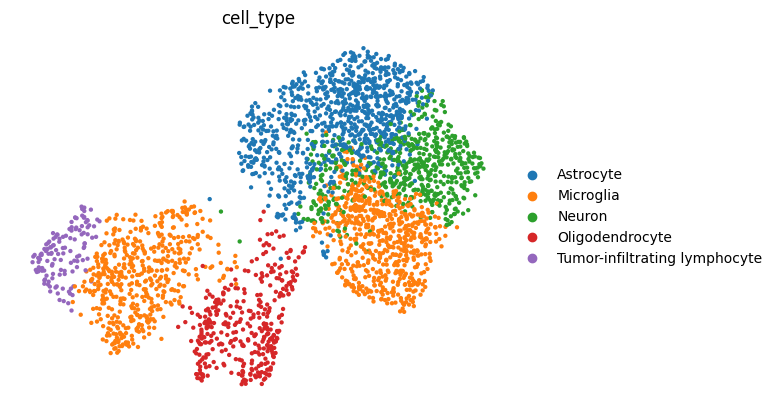

In [88]:
# To create a umap plot based on the new cell_type column
sc.pl.umap(adata, color = ['cell_type'], frameon = False)

In [89]:
# Making a subset of adata out of astrocyte and microglia data
subset = adata[adata.obs.cell_type.isin(['Astrocyte', 'Microglia'])].copy()

In [90]:
# Making a subset of adata out of astrocyte and oligodendrocyte data
ao = adata[adata.obs.cell_type.isin(['Astrocyte', 'Oligodendrocyte'])].copy()

In [91]:
ao.X

array([[-0.03408188, -0.98999835, -0.16580328, ...,  2.01950518,
         0.04552175, -0.75326894],
       [-0.03807118, -0.47436302, -0.16356181, ..., -0.7312026 ,
        -0.101262  ,  4.15492601],
       [-0.02842506, -0.76475309, -0.13380036, ...,  2.14316411,
         1.16305568, -0.84434474],
       ...,
       [-0.05896985, -0.57974717, -0.11333851, ..., -0.2893791 ,
        -0.57431514, -0.16857686],
       [-0.0241084 , -0.15452404, -0.08832112, ...,  3.60071728,
         3.26854731, -0.48564114],
       [ 0.01754165,  0.55397335, -0.00619041, ..., -2.26432404,
        -2.09442928, -1.06946471]])

In [92]:
subset.X

array([[-0.02018773, -0.64818199, -0.10579779, ..., -0.68874584,
        -0.86592741, -1.10408062],
       [-0.03232274, -0.95225254, -0.15558666, ...,  1.0094907 ,
         0.81658324,  1.39993629],
       [-0.0397481 , -1.09112712, -0.17470093, ..., -0.69102827,
         0.95537309,  1.24626118],
       ...,
       [-0.05896985, -0.57974717, -0.11333851, ..., -0.2893791 ,
        -0.57431514, -0.16857686],
       [ 0.01754165,  0.55397335, -0.00619041, ..., -2.26432404,
        -2.09442928, -1.06946471],
       [-0.07016925, -0.76172727, -0.13322781, ...,  5.22222343,
        -0.32898259, -0.02005308]])

In [93]:
# To make sure that there are no negative numbers in the array, since they were normalized beforehand
subset = subset.raw.to_adata()

In [94]:
# To make sure that there are no negative numbers in the array, since they were normalized beforehand
ao = ao.raw.to_adata()

In [95]:
# Filtering out genes with expression in less than 500 cells. To be changed to 200 just for testing later
sc.pp.filter_genes(subset, min_cells=500)

In [96]:
# Filtering out genes with expression in less than 500 cells. To be changed to 200 just for testing later
sc.pp.filter_genes(ao, min_cells=500)

In [97]:
ao.X.shape

(1254, 1648)

In [98]:
subset.write('astro_glia.h5ad')

In [99]:
ao.write('astro_oligod.h5ad')

### Diffxpy

In [ ]:
# !pip install diffxpy

In [100]:
# Using Diffxpy for DE
import diffxpy.api as de

In [ ]:
# Converting the ann data object into an array
# subset.X = np.array(subset.X) Unnecessary because it  is already an array

import scipy.sparse
if scipy.sparse.issparse(subset.X):
    subset.X = subset.X.toarray()

In [ ]:
len(subset.var)

In [ ]:
subset

In [ ]:
subset.var.sort_values(by='n_cells_by_counts').head()

In [ ]:
# Filtering out genes with expression in less than 500 cells. To be changed to 200 just for testing later
sc.pp.filter_genes(subset, min_cells=500)

In [ ]:
len(subset.var)

In [ ]:
subset.obs

In [ ]:
subset.X

In [ ]:
# Removing genes with zero variance
gene_vars = np.var(subset.X, axis=0)
subset = subset[:, gene_vars > 0]

In [ ]:
subset

In [ ]:
subset.var.shape

In [ ]:
subset.obs['size_factors'] = subset.X.sum(axis=1)

In [ ]:
res = de.test.wald(data=subset, formula_loc="~ 1 + cell_type", factor_loc_totest="cell_type")

In [ ]:
res = de.test.lrt(data=subset, full_formula_loc="~ 1 + cell_type", reduced_formula_loc="~ 1")

In [ ]:
res.summary().sort_values('log2fc', ascending = False).reset_index(drop = True)

### PyDeseq2

In [ ]:
# !pip install pydeseq2

In [100]:
from pydeseq2.ds import DeseqDataSet
from pydeseq2.ds import DeseqStats

In [101]:
import os
print(f"Number of CPUs available: {os.cpu_count()}")

Number of CPUs available: 12


In [102]:
# I choose 300 samples each from both cell types because beyond 300, running it became too computationally expensive
astrocytes = ao[ao.obs['cell_type'] == 'Astrocyte'][:300]
oligodendrocytes = ao[ao.obs['cell_type'] == 'Oligodendrocyte'][:300]

In [103]:
subset_adata = astrocytes.concatenate(oligodendrocytes)

In [104]:
subset_adata.X

array([[ 1,  5, 15, ..., 12, 10,  1],
       [ 4,  9,  3, ..., 10,  7,  5],
       [ 1, 13, 14, ..., 30,  4,  3],
       ...,
       [ 1,  0,  0, ...,  1,  0,  2],
       [ 4,  0,  0, ...,  0,  1,  0],
       [ 2,  1,  0, ...,  3,  1,  3]], dtype=int64)

In [105]:
# The genes should be the columns, unlike the traditional DESeq in R
counts_test = pd.DataFrame(subset_adata.X, columns=subset_adata.var_names, index=subset_adata.obs_names) 

In [106]:
# Explicitly creating categories with the instances in the cell_type column for the metadata df
metadata_test = subset_adata.obs[['cell_type']]
metadata_test = metadata_test.copy()
metadata_test['cell_type'] = metadata_test['cell_type'].astype('category')

In [107]:
# Setting up the deseq2 model
dds = DeseqDataSet(counts=counts_test,
                   metadata=metadata_test,
                   design_factors='cell_type', 
                   n_cpus=10,
                   ref_level=('cell_type', 'Oligodendrocyte'))

C:\Users\tobij\AppData\Local\Temp\ipykernel_14728\3843725937.py:2: UserWarning: Same factor names in the design contain underscores ('_'). They will
                be converted to hyphens ('-').
  dds = DeseqDataSet(counts=counts_test,


In [108]:
dds.obs

,cell-type
cell_27-0,Astrocyte
cell_37-0,Astrocyte
cell_41-0,Astrocyte
cell_63-0,Astrocyte
cell_65-0,Astrocyte
...,...
cell_2634-1,Oligodendrocyte
cell_2641-1,Oligodendrocyte
cell_2644-1,Oligodendrocyte
cell_2648-1,Oligodendrocyte


In [109]:
# Running the deseq2 analysis (The real deal)
import time
start_time = time.time()

dds.deseq2()

end_time = time.time()
print(f"Execution time: {end_time - start_time:.2f} seconds")

Fitting size factors...
... done in 0.05 seconds.

Fitting dispersions...
... done in 1.15 seconds.

Fitting dispersion trend curve...
... done in 0.06 seconds.

Fitting MAP dispersions...
... done in 1.04 seconds.

Fitting LFCs...
... done in 0.79 seconds.

Calculating cook's distance...
... done in 0.19 seconds.



Execution time: 10.13 seconds


Replacing 0 outlier genes.



In [110]:
stat_res = DeseqStats(dds)
stat_res.summary()

Running Wald tests...


Log2 fold change & Wald test p-value: cell-type Astrocyte vs Oligodendrocyte
         baseMean  log2FoldChange     lfcSE       stat        pvalue  \
SKA2     1.178100       -1.359325  0.132758 -10.239124  1.324300e-24   
NDUFB9   2.739282        0.812582  0.091502   8.880515  6.655168e-19   
CKS2     2.859155        1.332186  0.132534  10.051619  9.037049e-24   
CALR     2.965539        1.052522  0.103935  10.126756  4.203641e-24   
ARL6IP1  1.459472        0.304981  0.122013   2.499590  1.243371e-02   
...           ...             ...       ...        ...           ...   
AP2M1    2.135099        0.723884  0.099641   7.264902  3.733098e-13   
ATP5L    5.839907        0.284856  0.067439   4.223878  2.401342e-05   
COX7A2   7.765812        0.128095  0.066226   1.934198  5.308884e-02   
PCBP1    3.217035        0.790092  0.087789   8.999935  2.258522e-19   
TCF12    1.949539       -2.169848  0.124117 -17.482346  1.952950e-68   

                 padj  
SKA2     5.063682e-24  
NDUFB9   2

... done in 0.30 seconds.



In [111]:
print(dir(stat_res))

['LFC', 'SE', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_build_contrast', '_build_contrast_vector', '_cooks_filtering', '_fit_prior_var', '_independent_filtering', '_p_value_adjustment', 'alpha', 'alt_hypothesis', 'base_mean', 'contrast', 'contrast_idx', 'contrast_vector', 'cooks_filter', 'dds', 'design_matrix', 'independent_filter', 'inference', 'lfc_null', 'lfc_shrink', 'p_values', 'padj', 'plot_MA', 'prior_LFC_var', 'quiet', 'results_df', 'run_wald_test', 'shrunk_LFCs', 'statistics', 'summary']


In [112]:
df = stat_res.results_df

In [113]:
# Getting the differentially expressed genes and setting the log2FoldChange at double or half the expression and above
degs = df[(df.padj < 0.05) & (abs(df.log2FoldChange) > 1)].sort_values(by='log2FoldChange').dropna()

In [114]:
degs

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
SOX11,3.081117,-3.597185,0.152129,-23.645658,1.308193e-123,4.227259e-122
CCND2,5.158114,-3.316533,0.135562,-24.465024,3.482811e-132,1.366589e-130
FXYD6,2.748268,-3.229065,0.134753,-23.962792,6.797635e-127,2.435327e-125
GLCCI1,2.184442,-2.840597,0.141666,-20.051399,1.962484e-89,3.760667e-88
GADD45G,5.517839,-2.583477,0.142345,-18.149368,1.298870e-73,1.814016e-72
...,...,...,...,...,...,...
GEM,3.965163,4.710799,0.199060,23.665180,8.236714e-124,2.714821e-122
SAT1,12.801400,4.755951,0.142326,33.415866,8.065269e-245,1.476840e-242
ATF3,6.554987,4.760497,0.165933,28.689297,5.188712e-181,4.275499e-179
APOE,20.831743,5.209404,0.131883,39.500143,0.000000e+00,0.000000e+00


In [115]:
# Selecting the top 25 and bottom 25 gene names from the degs df
genes_to_show = degs[-25:].index.tolist() + degs[:25].index.tolist()

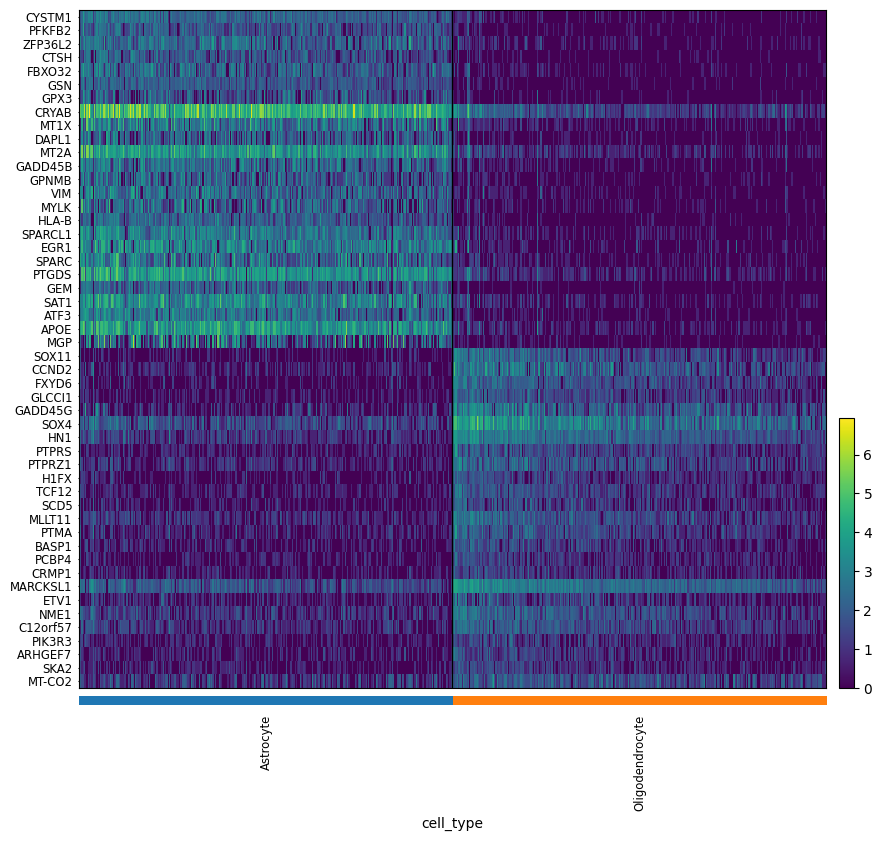

In [116]:
# Plotting a heatmap showing the expressions of the top over and underexpressed genes
sc.pl.heatmap(subset_adata, genes_to_show, groupby='cell_type', swap_axes=True, log=True)

### GO enrichment

In [118]:
# !pip install gseapy

In [119]:
import gseapy as gp

In [120]:
gp.get_library_name()
# 'GO_Biological_Process_2021',
#'KEGG_2021_Human',

['ARCHS4_Cell-lines',
 'ARCHS4_IDG_Coexp',
 'ARCHS4_Kinases_Coexp',
 'ARCHS4_TFs_Coexp',
 'ARCHS4_Tissues',
 'Achilles_fitness_decrease',
 'Achilles_fitness_increase',
 'Aging_Perturbations_from_GEO_down',
 'Aging_Perturbations_from_GEO_up',
 'Allen_Brain_Atlas_10x_scRNA_2021',
 'Allen_Brain_Atlas_down',
 'Allen_Brain_Atlas_up',
 'Azimuth_2023',
 'Azimuth_Cell_Types_2021',
 'BioCarta_2013',
 'BioCarta_2015',
 'BioCarta_2016',
 'BioPlanet_2019',
 'BioPlex_2017',
 'CCLE_Proteomics_2020',
 'CORUM',
 'COVID-19_Related_Gene_Sets',
 'COVID-19_Related_Gene_Sets_2021',
 'Cancer_Cell_Line_Encyclopedia',
 'CellMarker_2024',
 'CellMarker_Augmented_2021',
 'ChEA_2013',
 'ChEA_2015',
 'ChEA_2016',
 'ChEA_2022',
 'Chromosome_Location',
 'Chromosome_Location_hg19',
 'ClinVar_2019',
 'DGIdb_Drug_Targets_2024',
 'DSigDB',
 'Data_Acquisition_Method_Most_Popular_Genes',
 'DepMap_CRISPR_GeneDependency_CellLines_2023',
 'DepMap_WG_CRISPR_Screens_Broad_CellLines_2019',
 'DepMap_WG_CRISPR_Screens_Sanger_Cell

In [121]:
subset_adata

AnnData object with n_obs × n_vars = 600 × 1648
    obs: 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_genes', 'leiden', 'cell_type', 'batch'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
    uns: 'cell_type_colors'
    obsm: 'X_pca', 'X_umap'

In [124]:
# For the genes with increased expression in astrocytes
enr = gp.enrichr(gene_list= degs[degs.log2FoldChange > 1].index.tolist(),
                 gene_sets=['KEGG_2021_Human','GO_Biological_Process_2021'],
                 organism='human',
                 outdir=None, # To avoid writing to disk,
                 background = subset.var_names.tolist()
                )

In [126]:
gsea_res = enr.results

In [130]:
gsea_res.head()

,Gene_set,Term,P-value,Adjusted P-value,Old P-value,Old adjusted P-value,Odds Ratio,Combined Score,Genes
0,KEGG_2021_Human,Lysosome,1.724461e-08,0.000005,0,0,5.529309,98.840631,SCARB2;CTSA;CD63;ASAH1;SORT1;HEXB;SLC11A2;HEXA...
1,KEGG_2021_Human,Mineral absorption,1.130130e-07,0.000015,0,0,22.408189,358.436089,MT2A;FTH1;SLC11A2;ATP2B4;MT1G;MT1X;ATP1B3;ATP1...
2,KEGG_2021_Human,Kaposi sarcoma-associated herpesvirus infection,3.430241e-05,0.003076,0,0,3.517857,36.164609,GABARAPL2;JUN;CDKN1A;STAT3;HLA-B;HLA-C;HLA-A;F...
3,KEGG_2021_Human,Phagosome,6.764223e-05,0.004549,0,0,3.434641,32.976939,ITGB1;ATP6V0E1;HLA-B;M6PR;HLA-C;HLA-A;TUBB4B;A...
4,KEGG_2021_Human,Cellular senescence,1.325969e-04,0.007134,0,0,3.347011,29.882772,CDKN1A;GADD45B;GADD45A;CDKN2A;HLA-B;PTEN;HLA-C...


In [133]:
valid_gsea_res = gsea_res[gsea_res['Adjusted P-value'] < 0.05]

In [134]:
valid_gsea_res.Term

0                                               Lysosome
1                                     Mineral absorption
2        Kaposi sarcoma-associated herpesvirus infection
3                                              Phagosome
4                                    Cellular senescence
5                        Human cytomegalovirus infection
6                               Type I diabetes mellitus
7                                    Allograft rejection
8                             Autoimmune thyroid disease
9                              Graft-versus-host disease
10                   Antigen processing and presentation
11                    Cysteine and methionine metabolism
12                          Epstein-Barr virus infection
269    neutrophil activation involved in immune respo...
270                neutrophil degranulation (GO:0043312)
271            neutrophil mediated immunity (GO:0002446)
272              regulation of angiogenesis (GO:0045765)
273       regulation of cytokin